In [1]:
# One of the key factors of Eureka is that it tries 32 different approaches before taking the best one and its history. This is very similar to a MCTS.

In [ ]:
# Pseudocode:
# 1 system prompt to just write a train.py file
# 2 run this 32 times
# 3 execute all 32
# 4 take the best one and save its training history

# Prompt 2: Reward reflection and feedback
# 5 reward reflection and feedback
# 6 run this 32 times
# 7 execute all 32
# 8 take the best one and save its training history
# 9 repeat

In [1]:
import os

# Define the new working directory relative to the current working directory
# or use an absolute path
new_working_directory = os.path.join(os.getcwd(), '..', '..', '..') # Set to MLAgentBenhc
print("New working directory: ", new_working_directory)

# Change the current working directory
os.chdir(new_working_directory)

print("New Working Directory:", os.getcwd())

New working directory:  c:\Users\kevihuang\OneDrive - Microsoft\Desktop\projects\MLAgentBench\MLAgentBench_v2\agents\Eureka\..\..\..
New Working Directory: c:\Users\kevihuang\OneDrive - Microsoft\Desktop\projects\MLAgentBench


In [19]:
from MLAgentBench_v2.agents.agent import Agent
import numpy as np 
import json
import logging 
import os
import re
import subprocess
from pathlib import Path
import shutil
import time 
import types
import copy
import ast
import matplotlib.pyplot as plt

In [25]:
# Instantiate an environment
from types import SimpleNamespace
from MLAgentBench_v2.environment import Environment

args = SimpleNamespace(
    task='home-data-for-ml-course',
    task_type='kaggle',
    log_dir='logs/house-price-testing_eureka_gpt4_v6',
    work_dir='workspace',
    max_steps=50,
    max_time=18000,
    device=0,
    python='/home/user/micromamba/envs/autogpt/bin/python',
    interactive=False,
    resume=None,
    resume_step=0,
    agent_type='VoyagerAgent', # Just for instantiation -- doesn't actually do anything
    # llm_name='gpt-3.5-turbo-1106',
    # fast_llm_name='gpt-3.5-turbo-1106',
    # edit_script_llm_name='gpt-3.5-turbo-1106',
    llm_name='gpt-4-1106-preview',
    fast_llm_name='gpt-4-1106-preview',
    edit_script_llm_name='gpt-4-1106-preview',
    edit_script_llm_max_tokens=4000,
    agent_max_steps=50,
    actions_remove_from_prompt=[],
    actions_add_to_prompt=[],
    no_retrieval=False,
    valid_format_entires=None,
    max_steps_in_context=3,
    max_observation_steps_in_context=3,
    max_retries=4,
    langchain_agent='zero-shot-react-description'
)

env = Environment(args)

Initializing environment...
args namespace(task='home-data-for-ml-course', task_type='kaggle', log_dir='logs/house-price-testing_eureka_gpt4_v6', work_dir='workspace', max_steps=50, max_time=18000, device=0, python='/home/user/micromamba/envs/autogpt/bin/python', interactive=False, resume=None, resume_step=0, agent_type='VoyagerAgent', llm_name='gpt-4-1106-preview', fast_llm_name='gpt-4-1106-preview', edit_script_llm_name='gpt-4-1106-preview', edit_script_llm_max_tokens=4000, agent_max_steps=50, actions_remove_from_prompt=[], actions_add_to_prompt=[], no_retrieval=False, valid_format_entires=None, max_steps_in_context=3, max_observation_steps_in_context=3, max_retries=4, langchain_agent='zero-shot-react-description')
Preparing task home-data-for-ml-course , of type:  kaggle


In [26]:
# Define the directory path you want to create
directory_path = env.work_dir + '/eureka'

# Check if the directory already exists to avoid errors
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

In [27]:
# Pseudocode:
# 1 system prompt to just write a train.py file

class EurekaAgent(Agent):
    def __init__(self, env, completed_tasks=[], failed_tasks=[]):
        super().__init__(env)
        self.num_runs = 2
        self.mae_over_time = []

    def initial_system_prompt(self, env):
        # 1. Prepare the initial system prompt to get machine learning code
        self.system_prompt_initial = f'''You are a machine learning engineer trying to write machine learning code to solve machine learning tasks as effectively as possible.

Your goal is to write a machine learning script for the environment that will help the model achieve the highest accuracy possible on the research task described in text.

For evaluation, ensure that the machine learning script outputs the validation MAE (not MAE using log values but normal values).

I will give you the following information:
Research task: ...
Files: these are the current files and its contents that you have in your working directory to work with

The output format must be only executable python code, no conversation or explanation.
'''
        self.user_prompt_initial = ""
        for file in os.listdir(self.work_dir):
            args = {
                'file_name': file, 
                'update_files_action_result_history': False
            }
            self.user_prompt_initial += f'''Research task: {self.research_problem}\n\nFiles:\nFilename: {file}. \nContent: {self.available_actions['readFile'](**args)}\n'''
        print("\nSystem prompt: \n" + self.system_prompt_initial)
        print("\nUser prompt: \n" + self.user_prompt_initial)

        complete_task_args = {
            'system_prompt': self.system_prompt_initial,
            'user_prompt': self.user_prompt_initial,
            'max_tokens': 4096,
            'temperature': 1.0, # increase randomness as much as possible
            'top_p': 1.0,
            'update_files_action_result_history': False,
        }

        # Track raw results and MAE results
        mae_results, raw_results_after_script_execution, sorted_index_mae_results = self.sample_run_eval_actions(complete_task_args, 0)
        return mae_results, raw_results_after_script_execution, sorted_index_mae_results 

    def reward_reflection_and_feedback(self, env, round, best_MAE_feedback, best_MAE_filename):
        args = {
            'file_name': best_MAE_filename, 
            'update_files_action_result_history': False
        }
        best_code = f'''{self.available_actions['readFile'](**args)}\n'''

        self.system_prompt_initial = f'''We trained a machine learning model using the provided machine learning script and calculated the validation MAE and provided feedback:
{best_MAE_feedback}

Please carefully analyze the MAE and feedback and provide a new, improved machine learning script that can better solve the task.

Your goal is to write a machine learning script for the environment that will help the model achieve the highest accuracy possible on the research task described in text.

For evaluation, ensure that the machine learning script outputs the validation MAE (not MAE using log values but normal values).

I will give you the following information:
Research task: ...
Files: these are the current files and its contents that you have in your working directory to work with

Please analyze each existing component of the code as suggested by the feedback, and then write the machine learning script. 

The output format should be JSON. 
Example:
```json
{{
    "analysis": "<insert analysis based on feedback>",
    "code": "<insert python executable code>"
}}
```
'''
        self.user_prompt_initial = ""
        for file in os.listdir(self.work_dir):
            args = {
                'file_name': file, 
                'update_files_action_result_history': False
            }
            self.user_prompt_initial += f'''Research Goal: {self.research_problem}\nMAE Feedback: {best_MAE}\nFilename: {file}. Content: {self.available_actions['readFile'](**args)}\n'''
        print("\nSystem prompt: \n" + self.system_prompt_initial)
        print("\nUser prompt: \n" + self.user_prompt_initial)

        complete_task_args = {
            'system_prompt': self.system_prompt_initial,
            'user_prompt': self.user_prompt_initial,
            'max_tokens': 4096,
            'temperature': 1.0, # increase randomness as much as possible
            'top_p': 1.0,
            'update_files_action_result_history': False,
        }

        # Track raw results and MAE results
        mae_results, raw_results_after_script_execution, sorted_index_mae_results = self.sample_run_eval_actions(complete_task_args, 0)
        return mae_results, raw_results_after_script_execution, sorted_index_mae_results 

    def sample_run_eval_actions(self, complete_task_args, round_idx):
        mae_results = []
        raw_results_after_script_execution = []
        # b) sample 5 different actions
        for i in range(self.num_runs):
            # 2. Write as a python script and ensure that it's valid python code
            raw_output = env.complete_text_openai(**complete_task_args) 
            print("\nRaw output: \n" + raw_output)
            write_as_python_code_args = {
                'system_prompt': 'You are a helpful assistant. Please take the following code and return the content you would write into a python script file. Do not include the ```python or ``` at the beginning and end of the code.',
                'user_prompt': raw_output,
                'max_tokens': 4096,
                'temperature': 0.0,
                'top_p': 0.0,
                'update_files_action_result_history': False,
            }
            output = env.complete_text_openai(**write_as_python_code_args)
            
            # Write to file
            write_args = {
                'file_name': f'eureka/run_1_script_{i}.py',
                'content': output,
                'update_files_action_result_history': False,
            }
            env.write_file(**write_args)

            # c) Execute file
            execute_args = {
                'script_name': f'eureka/run_1_script_{i}.py',
                'update_files_action_result_history': False,
            }
            result = env.execute_script(**execute_args)
            
            # d) Take the best expected value, save output, code, and an explanation of why it was good, and why it was bad.
            # 1. Use chat_completion to 1) ensure that the code outputs the validation MAE and then 2) extract the validation MAE if it exists.
            # 2. Sort all the results
            # 3. Use chat completion to add more feedback about why the code was good and why it was bad.
            extract_val_MAE_args = {
                'system_prompt': '''You are a helpful assistant. Your goal is to check if the code outputs the validation MAE, specifically not as logged values, but normal values, and if so, then extract the validation MAE value from the result. If the code doesn't output the validation MAE or its not for normal values, then please write "inf" as the validation MAE. 
                
                Example:
                ```json
                {
                    "code_outputs_normal_val_MAE": <boolean>,
                    "val_MAE": <float>
                }''',
                'json_required': True,
                'user_prompt': result,
                'max_tokens': 4096,
                'temperature': 0.0,
                'top_p': 0.0,
                'update_files_action_result_history': False,
            }
            val_MAE = env.complete_text_openai(**extract_val_MAE_args)
            try:
                val_MAE = float(json.loads(val_MAE)['val_MAE'])
            except:
                val_MAE = 'inf'
            mae_results.append(val_MAE)
            raw_results_after_script_execution.append(result)

        # Sort the scripts based on their MAE values
        indexed_mae_results = [(index, value) for index, value in enumerate(mae_results)]
        sorted_index_mae_results = sorted(indexed_mae_results, key=lambda x: x[1])
        
        print(f"\n\n---ROUND {round_idx} RESULTS ---\n")
        print("\n\nRaw results after executing scripts\n")
        for idx, result in enumerate(raw_results_after_script_execution):
            print(f"\n\nRaw result {idx}:\n" + result)
        print("\n\nMAE results: ", mae_results)
        print("\n\nSorted results", sorted_index_mae_results)
        
        # Update MAE over time for tracking
        self.mae_over_time.append(sorted_index_mae_results)
        print("\n\nMAE over time: ", self.mae_over_time, "\n\n")
        self.plot_mae_over_time(self.mae_over_time, round_idx)

        return mae_results, raw_results_after_script_execution, sorted_index_mae_results 

    def plot_mae_over_time(self, mae_over_time, round_idx):
        # Preparing data for scatter plot
        x_values = []
        y_values = []

        for i, sublist in enumerate(mae_over_time):
            for value in sublist[1]:
                if value != 'inf':
                    x_values.append(i + 1)  # Adding 1 because list index starts at 0
                    y_values.append(value)

        # Creating scatter plot
        plt.scatter(x_values, y_values)
        plt.xlabel('List Index')
        plt.ylabel('Values')
        plt.title('Scatter Plot of Values vs. List Index')
        plt.savefig(f'workspace/home-data-for-ml-course_branch/eureka/mae_over_time_{round_idx}.png')

eureka_agent = EurekaAgent(env)



--- LOGGING NEW ACTION ---
Step: 0
Calling function wrapped_read_file(args = (), kwargs = {'file_name': 'data_description.txt', 'work_dir': 'workspace\\home-data-for-ml-course_branch'})

--- TOOL SUCCESS ---


--- Step: 1 not recorded in history

--- Step Action: Calling function wrapped_read_file(args = (), kwargs = {'file_name': 'data_description.txt', 'work_dir': '.'})

--- Step Result: MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER



--- Step: 3 not recorded in history

--- Step Action: Calling function wrapped_read_file(args = (), kwargs = {'file_name': 'research_problem.txt', 'work_dir': '.'})

--- Step Result: Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Evaluation
Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. You want a train and validation MAE of lower than 15,000 and there should be a submission.csv containing predictions for test.csv ready to submit.

Metric
Submissions are evalu

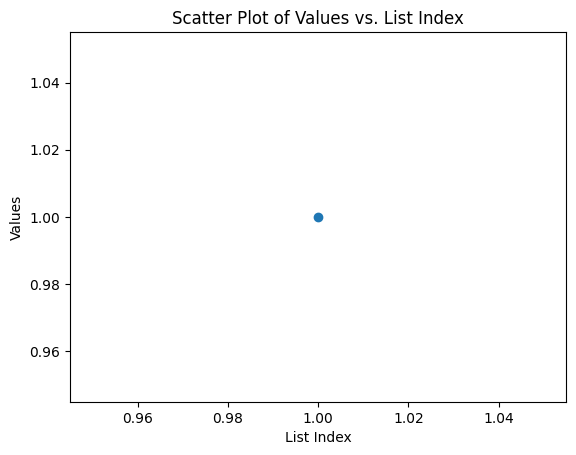

In [28]:
mae_results, raw_results, sorted_index_mae_results  = eureka_agent.initial_system_prompt(env)

MAE over time:  [[(1, 18113.61116438356), (0, inf), (2, inf)]]
sublist:  [(1, 18113.61116438356), (0, inf), (2, inf)]


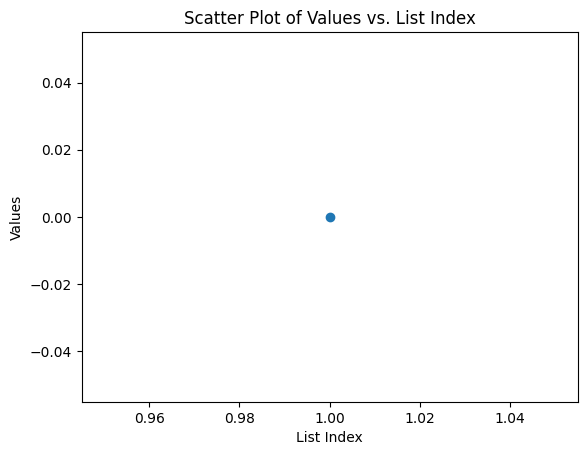

In [22]:
# Ideally I want to maintain a plot of the MAE results over time and expect to see them decrease over time
mae_over_time = [sorted_index_mae_results]
print("MAE over time: ", mae_over_time)

def plot_mae_over_time(mae_over_time):
    # Preparing data for scatter plot
    x_values = []
    y_values = []

    for i, sublist in enumerate(mae_over_time):
        print("sublist: ", sublist)
        for value in sublist[1]:
            if value != 'inf':
                x_values.append(i + 1)  # Adding 1 because list index starts at 0
                y_values.append(value)

    # Creating scatter plot
    plt.scatter(x_values, y_values)
    plt.xlabel('List Index')
    plt.ylabel('Values')
    plt.title('Scatter Plot of Values vs. List Index')
    plt.savefig(f'workspace/home-data-for-ml-course_branch/eureka/mae_over_time_{len(mae_over_time)}.png')
plot_mae_over_time(mae_over_time)

In [7]:
best_file = f'eureka/run_1_script_{sorted_index_mae_results[0][0]}.py'  
print("Best file: ", best_file)

Best file:  eureka/run_1_script_31.py


In [ ]:
top_results_over_time = [sorted_index_mae_results[0]]
print("\n\nUPDATED Round 1\n\nTop results over time: ", top_results_over_time)
for round in range(2, 5):
    mae_results, raw_results, sorted_index_mae_results = eureka_agent.reward_reflection_and_feedback(env, round, sorted_index_mae_results[0][1], file_name=f'eureka/run_1_script_{sorted_index_mae_results[0][0]}.py')
    top_results_over_time.append(sorted_index_mae_results[0])
    print("\n\nUPDATED Round", round, "\n\nTop results over time: ", top_results_over_time)

In [ ]:
# Prompt 2: Reward reflection and feedback
# 5 reward reflection and feedback
# 6 run this 32 times
# 7 execute all 32
# 8 take the best one and save its training history
# 9 repeat

In [ ]:
# 2 run this 32 times
# 3 execute all 32
# 4 take the best one and save its training history -- tbh not sure if there's a standardized way to do this? Perhaps have an agent extract just the MAE and just grab the best one. Mini waste of tokens, but it's very little. 

# Prompt 2: Reward reflection and feedback
# 5 reward reflection and feedback
# 6 run this 32 times
# 7 execute all 32
# 8 take the best one and save its training history
# 9 repeat